# gnomAD Analysis

We'd like to estimate what genes are enriched for loss of function (LoF) variants
in specific GnomAD populations relative to non-Finnish Europeans (NFE). Since we 
are interested in LoF variants, I'm looking at the GnomAD exome VCF file.

We'll use the PIEMM model introduced in http://biorxiv.org/content/early/2016/09/25/077180. 

In [1]:
import cPickle
import os

import matplotlib as mpl

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
import scipy.stats as stats
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']

from IPython.display import display, HTML

%matplotlib inline
%load_ext rpy2.ipython

outdir = '../output/gnomad_analysis'
if not os.path.exists(outdir):
    os.makedirs(outdir)
private_outdir = '../private_output/gnomad_analysis'
if not os.path.exists(private_outdir):
    os.makedirs(private_outdir)

In [3]:
fn = '/srv/gsfs0/projects/rivas/data/gencode.v19_20170302/parsing/gencode.v19.annotation.table.tsv'
gtable = pd.read_table(fn, index_col=0)
gtable['gencode_id'] = gtable.index
gtable.index = [x.split('.')[0] for x in gtable.index]

fn = '/srv/gsfs0/projects/rivas/data/gnomad_170228_20170228/parsing/gnomad.exomes.r2.0.1.sites.tsv'
cols = {'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
        'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
        'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
        'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Allele':str,
        'Consequence':str, 'IMPACT':str, 'Gene':str, 'BIOTYPE':str, 'SIFT':str, 
        'PolyPhen':str, 'CLIN_SIG':str, 'LoF':str, 'LoF_filter':str, 
        'LoF_flags':str, 'LoF_info':str}
cols_to_read = set(cols.keys())
cols_to_read -= set(['Allele', 'BIOTYPE'])
vrs = pd.read_table(fn,
                    dtype={'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
                           'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
                           'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
                           'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Allele':str,
                           'Consequence':str, 'IMPACT':str, 'Gene':str, 'BIOTYPE':str, 'SIFT':str, 
                           'PolyPhen':str, 'CLIN_SIG':str, 'LoF':str, 'LoF_filter':str, 
                           'LoF_flags':str, 'LoF_info':str},
                    usecols=cols_to_read)
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]

In [4]:
# Maximum number of chromosomes genotyped per population.
pop_max = vrs[['AN_{}'.format(x) for x in pops]].max()
pop_max.index = [x.split('_')[1] for x in pop_max.index]

In [5]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]
    
for pop in pops:
    vrs['GP_{}'.format(pop)] = vrs['AN_{}'.format(pop)].astype(float) / pop_max[pop]
    
lof_only = vrs.dropna(subset=['LoF'])

## Explore GnomAD Variants

Let's explore the VCF a bit.

In [6]:
print('{:,} total variants.'.format(vrs.shape[0]))
gene_vc = vrs.Gene.value_counts()
print('{:,} distinct genes.'.format(gene_vc.shape[0]))
lof_only = vrs.dropna(subset=['LoF'])
print('{:,} LoF variants.'.format(lof_only.shape[0]))
vc = lof_only.LoF.value_counts()
print('{:,} HC and {:,} LC LoF variants.'.format(vc['HC'], vc['LC']))
print('Populations: {}'.format(', '.join(pops)))

13,717,608 total variants.
32,550 distinct genes.
496,725 LoF variants.
460,495 HC and 36,230 LC LoF variants.
Populations: AFR, AMR, ASJ, EAS, FIN, NFE, OTH, SAS


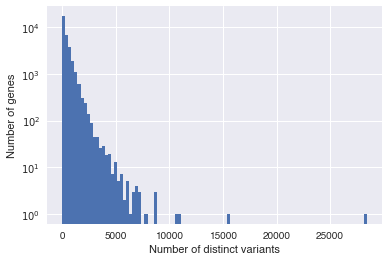

In [7]:
gene_vc.hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of distinct variants');

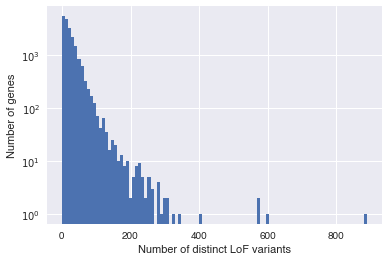

In [8]:
lof_only.Gene.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of distinct LoF variants');

We can see that most genes have less than 200 LoF variants.

In [9]:
vrs.Consequence.value_counts()

missense_variant                      5168333
intron_variant                        3398408
synonymous_variant                    2370523
non_coding_transcript_exon_variant     750539
splice_region_variant                  579445
3_prime_UTR_variant                    436885
5_prime_UTR_variant                    287302
frameshift_variant                     245232
stop_gained                            163346
inframe_deletion                        79711
splice_donor_variant                    58951
splice_acceptor_variant                 49120
upstream_gene_variant                   38704
inframe_insertion                       28786
start_lost                              19174
downstream_gene_variant                 15079
stop_lost                               11022
intergenic_variant                       5320
stop_retained_variant                    3827
mature_miRNA_variant                     3398
coding_sequence_variant                  1569
protein_altering_variant          

In [10]:
mis_only = vrs[vrs.Consequence == 'missense_variant']

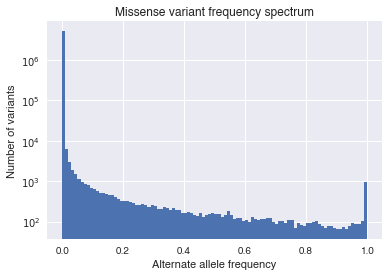

In [11]:
mis_only.AF_NFE.hist(bins=np.arange(0, 1.01, 0.01), log=True)
plt.title('Missense variant frequency spectrum')
plt.ylabel('Number of variants')
plt.xlabel('Alternate allele frequency');

In [ ]:
kjj